In [4]:
import xgboost as xg
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

NFOLDS = 5
SEED = 42
VALID = True
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
 

def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

print("\nData Load Stage")
training = pd.read_csv('train.csv.zip', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
desc_stem = pd.read_csv('train_all_features.csv')[['title_stemm', 'description_stemm']]
training[['title', 'description']] = desc_stem


Data Load Stage


In [17]:
training.title = desc_stem.title_stemm.values
training.description  = desc_stem.description_stemm.values

In [20]:
training_img = pd.read_csv('train_img_features_v1.csv',index_col = "item_id")
test_img = pd.read_csv('test_img_features_v1.csv',index_col = "item_id")

In [21]:
testing = pd.read_csv('test.csv.zip', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index
desc_stem = pd.read_csv('test_all_features.csv')[['title_stemm', 'description_stemm']]

testing.title = desc_stem.title_stemm.values
testing.description  = desc_stem.description_stemm.values

gp = pd.read_csv('aggregated_features.csv') 
training = training.merge(gp, on='user_id', how='left')
testing = testing.merge(gp, on='user_id', how='left')

training.index = traindex
testing.index =testdex

training = training.merge(training_img, left_index=True, right_index=True)
testing = testing.merge(test_img, left_index=True, right_index=True)



agg_cols = list(gp.columns)[1:]

del gp, desc_stem
gc.collect()

120

In [23]:
ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Train shape: 1503424 Rows, 33 Columns
Test shape: 508438 Rows, 30 Columns
Combine Train and Test


/home/dex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':



All Data shape: 2011862 Rows, 36 Columns


In [24]:
df['image'] =df['image_x']
df.drop(['image_x', 'image_y'], axis = 1, inplace  = True)

In [25]:
df['has_image'] = 1
df.loc[df['image'].isnull(), 'has_image'] = 0

df['price_is_null'] = 0
df.loc[df['price'].isnull(), 'price_is_null'] = 1

df['param_1_is_null'] = 0
df.loc[df['param_1'].isnull(), 'param_1_is_null'] = 1
df['param_2_is_null'] = 0
df.loc[df['param_2'].isnull(), 'param_2_is_null'] = 1
df['param_3_is_null'] = 0
df.loc[df['param_3'].isnull(), 'param_3_is_null'] = 1
df['image_top_1_is_null'] = 0

In [26]:
df['description'] = df['description'].apply(lambda x: str(x).replace('/\n', ' ').replace('\xa0', ' ').replace('.', ' . ').replace(',', ' , ')).replace(')', ' ) ').replace('(', ' ( ')

In [27]:
for col in agg_cols:
    df[col].fillna(-1, inplace=True)

print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday 
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str)) 


Feature Engineering

Create Time Variables


/home/dex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """



Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [30]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
#df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols + "count_words_upper"] = df[cols].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    #Letter count
    df[cols + '_count_letters']=df[cols].apply(lambda x: len(str(x)))
    #punctuation count
    df[cols + "count_punctuations"] = df[cols].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    #title case words count
    df[cols + "count_words_title"] = df[cols].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    #Number of stopwords
    #df[cols + "count_stopwords"] = df[cols].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('russian')]))
    #Average length of the words
    df[cols + "mean_word_len"] = df[cols].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    df[cols + "english_letters"] = df[cols].apply(lambda x: len([c for c in str(x) if c in string.ascii_letters]))
    df[cols + "english_prop_letters"] = df[cols + "english_letters"]/df[cols + '_count_letters']
    

df['words_vs_unique_description'] = df['description_num_unique_words'] / df['description_num_words'] * 100
df['title_desc_len_ratio'] = df['title_count_letters']/df['description_count_letters']


df['len_description'] = df['description'].apply(lambda x: len(x)) 
df['average_description_word_length'] = df['len_description'] / df['description_num_words']

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=45000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('titleCount',CountVectorizer(
            ngram_range=(1, 3),
            stop_words = russian_stop,
            preprocessor=get_col('title'))
        ),
       ('titleTF',TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=50000,
            **tfidf_para,
            preprocessor=get_col('title'))
        )  ])
    
start_vect=time.time()

vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

 
 
ridge_params = {'alpha':32.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':2000, 'tol':0.0001, 'solver':'auto', 'random_state':SEED}

 
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])
rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
df['ridge_preds'] = ridge_preds
print("Modeling Stage")

#svd features and nime features were precalculated 
train_f = pd.read_csv('train_all_features.csv')[['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_title_4',
       'svd_title_5', 'svd_title_6', 'svd_title_7', 'svd_title_8',
       'svd_title_9', 'svd_title_10', 'svd_description_1', 'svd_description_2',
       'svd_description_3', 'svd_description_4', 'svd_description_5',
       'svd_description_6', 'svd_description_7', 'svd_description_8',
       'svd_description_9', 'svd_description_10',  'svd_text_1',
       'svd_text_2', 'svd_text_3', 'svd_text_4', 'svd_text_5', 'svd_text_6',
       'svd_text_7', 'svd_text_8', 'svd_text_9', 'svd_text_10']]
test_f = pd.read_csv('test_all_features.csv')[['svd_title_1', 'svd_title_2', 'svd_title_3', 'svd_title_4',
       'svd_title_5', 'svd_title_6', 'svd_title_7', 'svd_title_8',
       'svd_title_9', 'svd_title_10', 'svd_description_1', 'svd_description_2',
       'svd_description_3', 'svd_description_4', 'svd_description_5',
       'svd_description_6', 'svd_description_7', 'svd_description_8',
       'svd_description_9', 'svd_description_10',  'svd_text_1',
       'svd_text_2', 'svd_text_3', 'svd_text_4', 'svd_text_5', 'svd_text_6',
       'svd_text_7', 'svd_text_8', 'svd_text_9', 'svd_text_10']]
svd_feat = train_f.append(test_f, ignore_index=True)
del train_f, test_f
gc.collect()
svd_feat.index = df.index
df = df.merge(svd_feat, left_index=True, right_index=True, how='inner')

cols = ['resnet_nima_feature_0', 'resnet_nima_feature_1',
       'resnet_nima_feature_2', 'resnet_nima_feature_3',
       'resnet_nima_feature_4', 'resnet_nima_feature_5',
       'resnet_nima_feature_6', 'resnet_nima_feature_7',
       'resnet_nima_feature_8', 'resnet_nima_feature_9']
train_f = pd.read_csv('resnet_scores_train.csv', index_col = "item_id")[cols]
test_f = pd.read_csv('resnet_scores_test.csv', index_col = "item_id")[cols]

svd_feat = train_f.append(test_f, ignore_index= False)
df = df.merge(svd_feat, left_index=True, right_index=True, how='inner')

del svd_feat
gc.collect()
#ridge_preds = pd.read_csv('ridge_preds0229.csv')['0']
# Combine Dense Features with Sparse Text Bag of Words Features



Text Features


/home/dex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 12.73 Minutes
Ridge OOF RMSE: 0.23014477104271705
Modeling Stage


63

In [31]:
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

1503424 Rows and 2622081 Cols
508438 Rows and 2622081 Cols
Feature Names Length:  2622081


In [32]:
print("\nModeling Stage")

del vectorizer,ready_df
gc.collect();


Modeling Stage


In [33]:
lgbm_params = {
   
        'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15, # if you use tf-idf dont use max_depth
    'num_leaves': 360, #optimal that used top 20 - was 400 leaves
    'feature_fraction': 0.55,
    'bagging_fraction': 0.75,
    #'bagging_freq': 2,
    'learning_rate': 0.018, #optimal that used top 20 - was 0.1
    'verbose': 100,
    'max_bin':500 #higher that default value 250 increase accuracy
}

In [ ]:
#1st aproach to train - averaging across folds
from sklearn.model_selection import KFold

import datetime
print(datetime.datetime.now())

folds = KFold(n_splits=5, shuffle=True, random_state=50001)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(testing.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    dtrain =lgb.Dataset(X.tocsr()[trn_idx], y.iloc[trn_idx])
    dval =lgb.Dataset(X.tocsr()[val_idx], y.iloc[val_idx])
    m_gbm=lgb.train(params=lgbm_params,train_set=dtrain,num_boost_round=1300,verbose_eval=400,
                    valid_sets=[dtrain,dval],valid_names=['train','valid'])
    oof_preds[val_idx] = m_gbm.predict(X.tocsr()[val_idx])
    sub_preds += m_gbm.predict(testing) / folds.n_splits
    print('Fold %2d rmse : %.6f' % (n_fold + 1, rmse(y.iloc[val_idx],oof_preds[val_idx])))
    del dtrain,dval
    gc.collect()
    
print('Full RMSE score %.6f' % rmse(y, oof_preds))   

del X; gc.collect()
sub_preds[sub_preds<0]=0
sub_preds[sub_preds>1]=1
 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
Submission=pd.read_csv("sample_submission.csv")
Submission['deal_probability']=sub_preds
Submission.to_csv("split5.csv", index=False)
print(datetime.datetime.now())


In [ ]:
#2st aproach to train - averaging across folds + creating meta

from sklearn.model_selection import KFold
X_meta = np.zeros((1503424, 1))

import datetime
print(datetime.datetime.now())

folds = KFold(n_splits=2, shuffle=True, random_state=50001)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(testing.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    dtrain =lgb.Dataset(X.tocsr()[trn_idx], y.iloc[trn_idx])
    dval =lgb.Dataset(X.tocsr()[val_idx], y.iloc[val_idx])
    m_gbm=lgb.train(params=lgbm_params,train_set=dtrain,num_boost_round=1300,verbose_eval=400,
                    valid_sets=[dtrain,dval],valid_names=['train','valid'])
    oof_preds[val_idx] = m_gbm.predict(X.tocsr()[val_idx])
    sub_preds += m_gbm.predict(testing) / folds.n_splits
    
    X_meta[val_idx] = m_gbm.predict(X.tocsr()[val_idx])
    
    print('Fold %2d rmse : %.6f' % (n_fold + 1, rmse(y.iloc[val_idx],oof_preds[val_idx])))
    del dtrain,dval
    gc.collect()
    
print('Full RMSE score %.6f' % rmse(y, oof_preds))   

del X; gc.collect()
sub_preds[sub_preds<0]=0
sub_preds[sub_preds>1]=1
np.save('meta_fold5stemNima.npy', X_meta)

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
Submission=pd.read_csv("fold5stemNima.csv")
Submission['deal_probability']=sub_preds
Submission.to_csv("split5.csv", index=False)
print(datetime.datetime.now())


/home/dex/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Model Evaluation Stage


/home/dex/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


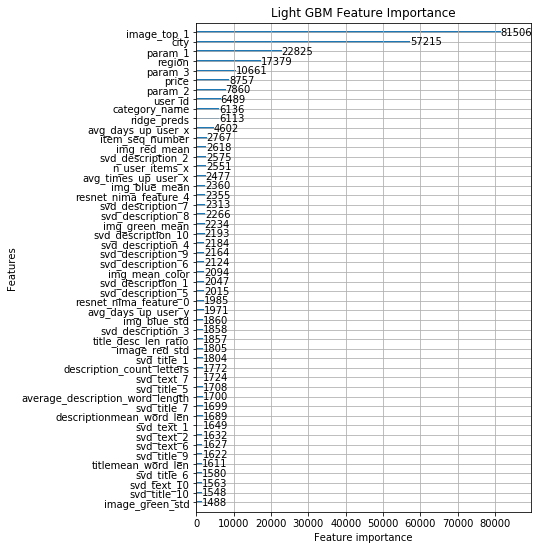

In [34]:
#3st aproach to train - validate or just train
VALID = False
if VALID == True:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.10, random_state=23)
        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    #del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=15,
        verbose_eval=100
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
    #del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1300,
        verbose_eval=100
    )

# Feature Importance Plot
f, ax = plt.subplots(figsize=[6,9])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance") 

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 

#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub_maxbin.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

In [35]:
import datetime
datetime.datetime.now()

datetime.datetime(2018, 6, 25, 7, 37, 1, 840404)

Text(0.5,1,'Light GBM Feature Importance')

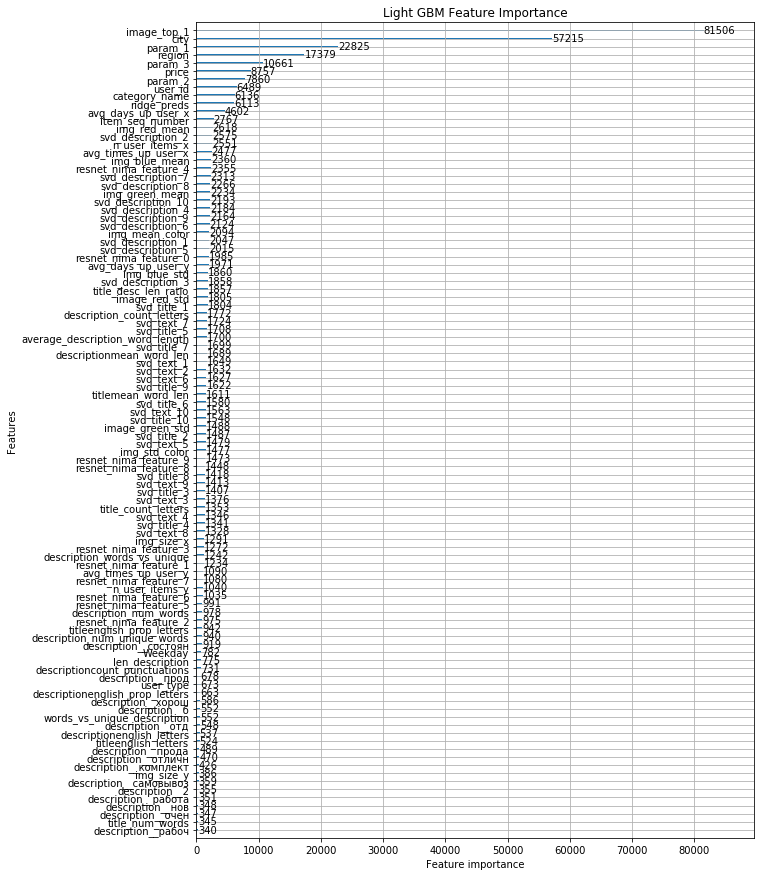

In [36]:
f, ax = plt.subplots(figsize=[10,15])
lgb.plot_importance(lgb_clf, max_num_features=100, ax=ax)
plt.title("Light GBM Feature Importance") 